In [2]:
import csv
import pandas as pd

In [3]:
import numpy as np
from sklearn.decomposition import PCA

In [21]:
sp_df = pd.read_csv('./ProData/csvs/skill_player_stats.csv', header=0)

In [13]:
sp_df.columns

Index(['Unnamed: 0', 'age', 'team', 'g', 'gs', 'targets', 'rec', 'rec_yds',
       'rec_yds_per_rec', 'rec_td', 'rec_first_down', 'rec_long', 'rec_per_g',
       'rec_yds_per_g', 'catch_pct', 'rec_yds_per_tgt', 'rush_att', 'rush_yds',
       'rush_td', 'rush_first_down', 'rush_long', 'rush_yds_per_att',
       'rush_yds_per_g', 'rush_att_per_g', 'touches', 'yds_per_touch',
       'yds_from_scrimmage', 'rush_receive_td', 'fumbles', 'av', 'player_id',
       'position', 'snaps_played', 'total_snaps', 'snap_played_percentage'],
      dtype='object')

In [37]:
dropped_fb = sp_df[sp_df.position != 'FB']

In [58]:
reindexed = dropped_fb.drop(['Unnamed: 0', 'team', 'av'], axis=1).set_index(['player_id', 'age', 'position'])

## Fillna for each player with the player's average
Snap Data was only available starting in 2012. For players that span across those time ranges, use their average to fill data from time before it was available.

In [60]:
fillna_cols = ['snap_played_percentage', 'snaps_played', 'total_snaps']

def fill_with_player_averages(group):
    group[fillna_cols] = group[fillna_cols].fillna(group[fillna_cols].mean())
    return group

In [61]:
new = reindexed.groupby('player_id', as_index=False).apply(fill_with_player_averages)

In [62]:
len(reindexed[reindexed.isnull().any(axis=1)])

4071

In [63]:
len(new[new.isnull().any(axis=1)])

2902

### Able to reduce number of null snap count data by about 25%

## Fill null snap data
Find average snap data for each position based on games started and games not started. Plug that in to null data.

So if Running Backs who started 12 games and featured in 3 averaged 80% of snaps, a running back who started 12 games and featured in 3 with null snap data will get 80% as well.


In [85]:
def fill_with_player_averages_from_game_data(group):
    group[fillna_cols] = group[fillna_cols].fillna(group[fillna_cols].mean())
    return group

In [64]:
new['games_played_not_started'] = new['g'] - new['gs']

In [68]:
new[new.isnull().any(axis=1)]

,,,g,gs,targets,rec,rec_yds,rec_yds_per_rec,rec_td,rec_first_down,rec_long,rec_per_g,...,rush_att_per_g,touches,yds_per_touch,yds_from_scrimmage,rush_receive_td,fumbles,snaps_played,total_snaps,snap_played_percentage,games_played_not_started
player_id,age,position,,,,,,,,,,,,,,,,,,,,,
BechAn00,34,TE,9,5,4,3,26,8.7,0,2,16,0.3,...,0.0,3,8.7,26,0,0,NaN,NaN,NaN,4
ThomIa00,22,TE,16,6,49,36,333,9.3,2,20,31,2.3,...,0.0,36,9.3,333,2,0,NaN,NaN,NaN,10
ThomJo05,22,TE,16,10,27,20,215,10.8,4,12,39,1.3,...,0.0,20,10.8,215,4,0,NaN,NaN,NaN,6
ShocJe00,22,TE,15,14,128,74,894,12.1,2,49,30,4.9,...,0.0,74,12.1,894,2,3,NaN,NaN,NaN,1
WrigGe00,22,TE,15,1,20,13,150,11.5,2,9,30,0.9,...,0.0,13,11.5,150,2,0,NaN,NaN,NaN,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
JacoJo01,21,RB,13,13,27,20,166,8.3,0,8,28,1.5,...,18.6,262,5.0,1316,7,1,NaN,NaN,NaN,0
BarkSa00,21,RB,16,16,121,91,721,7.9,4,30,57,5.7,...,16.3,352,5.8,2028,15,0,NaN,NaN,NaN,0
PortCl00,21,RB,16,12,49,33,364,11.0,2,16,66,2.1,...,17.1,306,6.1,1872,17,5,NaN,NaN,NaN,4


In [79]:
grouped = new.groupby(['position', 'gs', 'games_played_not_started'])

In [84]:
for grouping, group in grouped:
    if grouping == ('RB', 12, 4):
        print(group['snap_played_percentage'].mean())

0.4266666666666666


In [94]:
smart_fill = new.groupby(['position', 'gs', 'games_played_not_started']).apply(fill_with_player_averages)

In [96]:
test.query('player_id == "PortCl00"')

g  gs  targets  rec  rec_yds  rec_yds_per_rec  \
player_id age position                                                   
PortCl00  22  RB        13  13       51   38      314              8.3   
          23  RB        15  15       57   40      235              5.9   
          24  RB        16  16       41   30      216              7.2   
          28  RB         8   8       12    9       57              6.3   
          29  RB         5   5        9    5       55             11.0   
          25  RB         8   7       26   17      170             10.0   
          26  RB        16  16       60   47      389              8.3   
          27  RB        16  16       35   28      218              7.8   
          21  RB        16  12       49   33      364             11.0   

                        rec_td  rec_first_down  rec_long  rec_per_g  ...  \
player_id age position                                               ...   
PortCl00  22  RB             0              10        72        2.9  ...   
          23  RB             2              10        18        2.7  ...   
          24  RB             0              13        23        1.9  ...   
          28  RB             1               2        10        1.1  ...   
          29  RB             0               4        14        1.0  ...   
          25  RB             0               4        74        2.1  ...   
          26  RB             0              19        54        2.9  ...   
          27  RB             0              11        29        1.8  ...   
          21  RB             2              16        66        2.1  ...   

                        rush_att_per_g  touches  yds_per_touch  \
player_id age position                                           
PortCl00  22  RB                  22.3      328            5.8   
          23  RB                  22.9      383            4.0   
          24  RB                  22.0      382            4.5   
          28  RB                  15.5      133            4.1   
          29  RB                  10.8       59            4.8   
          25  RB                  15.9      144            4.8   
          26  RB                  20.3      372            4.4   
          27  RB                  21.4      370            4.6   
          21  RB                  17.1      306            6.1   

                        yds_from_scrimmage  rush_receive_td  fumbles  \
player_id age position                                                 
PortCl00  22  RB                      1905               14        3   
          23  RB                      1550                7        5   
          24  RB                      1732               11        3   
          28  RB                       551                2        1   
          29  RB                       282                2        0   
          25  RB                       693                7        0   
          26  RB                      1651               11        6   
          27  RB                      1705                9        3   
          21  RB                      1872               17        5   

                        snaps_played  total_snaps  snap_played_percentage  \
player_id age position                                                      
PortCl00  22  RB          417.464286   732.128968                0.526619   
          23  RB          513.804206   862.334286                0.565077   
          24  RB          602.385859   980.316162                0.600105   
          28  RB          325.333333   518.333333                0.630000   
          29  RB          216.750000   467.875000                0.535000   
          25  RB          150.000000   500.000000                0.300000   
          26  RB          602.385859   980.316162                0.600105   
          27  RB          602.385859   980.316162                0.600105   
          21  RB          447.250000  1013.083333                0.426667   

     

In [97]:
len(smart_fill[smart_fill.isnull().any(axis=1)])

59

## For any left over nulls, fill with position average for games started

In [100]:
dumb_fill = smart_fill.groupby(['position', 'gs']).apply(fill_with_player_averages)

In [104]:
clean_data = dumb_fill.drop('games_played_not_started', axis=1)

In [107]:
# penalize fumbles
clean_data['fumbles'] = clean_data['fumbles'] * -1

In [108]:
clean_data.mean()

g                          11.637301
gs                          5.747667
targets                    39.726380
rec                        24.899623
rec_yds                   288.707876
rec_yds_per_rec             9.812330
rec_td                      1.758310
rec_first_down             13.837891
rec_long                   30.830195
rec_per_g                   1.935566
rec_yds_per_g              22.154364
catch_pct                  59.194629
rec_yds_per_tgt             6.154921
rush_att                   29.685115
rush_yds                  126.527428
rush_td                     0.875225
rush_first_down             6.395448
rush_long                  11.469953
rush_yds_per_att            2.272376
rush_yds_per_g             10.047405
rush_att_per_g              2.392173
touches                    54.584739
yds_per_touch               8.999312
yds_from_scrimmage        415.235304
rush_receive_td             2.633535
fumbles                    -0.769609
snaps_played              356.229149
t

In [109]:
norm_cols = [col for col in clean_data.columns] 

In [255]:
normalized_qb_df = qbs_df

In [118]:
normalized_data = clean_data.groupby('position').apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [137]:
ndf = normalized_data.reset_index(['age', 'position', 'player_id'])
set(ndf['position'].values)

{'RB', 'TE', 'WR'}

In [135]:
normalized_rb = ndf[ndf['position'] == 'RB'].set_index(['player_id', 'age']).drop('position', axis=1)

In [138]:
normalized_te = ndf[ndf['position'] == 'TE'].set_index(['player_id', 'age']).drop('position', axis=1)

In [139]:
normalized_wr = ndf[ndf['position'] == 'WR'].set_index(['player_id', 'age']).drop('position', axis=1)

# Running Back Plots

In [140]:
pca = PCA(n_components=1)

In [141]:
pca_analysis = pd.DataFrame(
    pca.fit_transform(normalized_rb), 
    columns=['PCA%i' % i for i in range(1)], 
    index=normalized_rb.index)

# Plot Age vs Feature

In [142]:
import matplotlib.pyplot as plt

In [143]:
pca_analysis.reset_index('age', inplace=True)

In [144]:
top_50 = pca_analysis.sort_values('PCA0', axis=0, ascending=False).head(50)

In [192]:
top_50

In [193]:
#top_50.groupby('player_id').size()

In [194]:
#pca_analysis.sort_values('PCA0', axis=0).head(20)

In [174]:
players_per_age = pca_analysis.groupby('age').size().to_frame().reset_index('age')

In [178]:
players_per_age = players_per_age[players_per_age['age'] != 0]

In [181]:
average_pca_per_age = pca_analysis.groupby('age').mean().reset_index('age')
average_pca_per_age = average_pca_per_age[average_pca_per_age['age'] != 0]

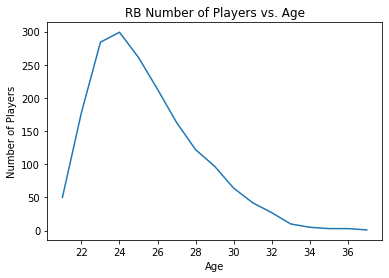

In [229]:
plt.plot(players_per_age['age'], players_per_age[0])
plt.title('RB Number of Players vs. Age')
plt.xlabel('Age')
plt.ylabel('Number of Players')
plt.savefig('players_v_age.png')
plt.show()

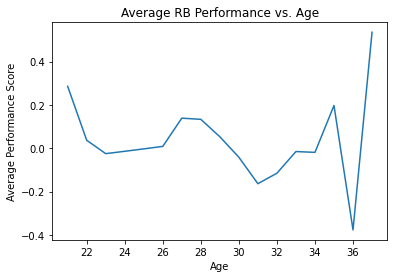

In [230]:
plt.plot(average_pca_per_age['age'], average_pca_per_age['PCA0'])
plt.title('Average RB Performance vs. Age')
plt.xlabel('Age')
plt.ylabel('Average Performance Score')
plt.savefig('perf_v_age.png')
plt.show()

# Wide Receiver Plots

In [140]:
pca = PCA(n_components=1)

In [195]:
wr_pca_analysis = pd.DataFrame(
    pca.fit_transform(normalized_wr), 
    columns=['PCA%i' % i for i in range(1)], 
    index=normalized_wr.index)

# Plot Age vs Feature

In [198]:
wr_pca_analysis.reset_index('age', inplace=True)

In [220]:
wr_top_50 = wr_pca_analysis.sort_values('PCA0', axis=0, ascending=False).head(50)

In [222]:
#wr_top_50

In [193]:
#top_50.groupby('player_id').size()

In [194]:
#pca_analysis.sort_values('PCA0', axis=0).head(20)

In [199]:
wr_players_per_age = wr_pca_analysis.groupby('age').size().to_frame().reset_index('age')

In [200]:
wr_players_per_age = wr_players_per_age[wr_players_per_age['age'] != 0]

In [201]:
wr_average_pca_per_age = wr_pca_analysis.groupby('age').mean().reset_index('age')
wr_average_pca_per_age = wr_average_pca_per_age[wr_average_pca_per_age['age'] != 0]

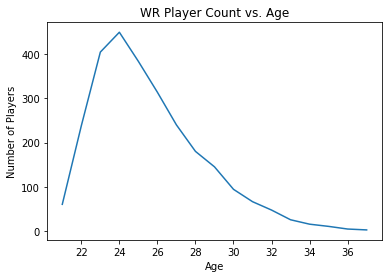

In [231]:
fig, ax = plt.subplots()
plt.plot(wr_players_per_age['age'], wr_players_per_age[0])
plt.title('WR Player Count vs. Age')
plt.xlabel('Age')
plt.ylabel('Number of Players')
plt.savefig('wr_players_v_age.png')
plt.show()

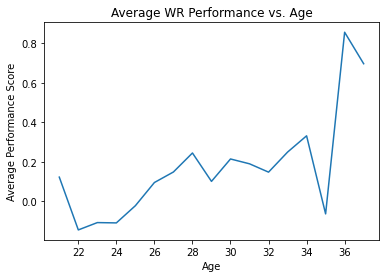

In [232]:
fig, ax = plt.subplots()
plt.plot(wr_average_pca_per_age['age'], wr_average_pca_per_age['PCA0'])
plt.title('Average WR Performance vs. Age')
plt.xlabel('Age')
plt.ylabel('Average Performance Score')
plt.savefig('wr_perf_v_age.png')
plt.show()

# Tight End Plots

In [140]:
pca = PCA(n_components=1)

In [207]:
te_pca_analysis = pd.DataFrame(
    pca.fit_transform(normalized_te), 
    columns=['PCA%i' % i for i in range(1)], 
    index=normalized_te.index)

# Plot Age vs Feature

In [208]:
te_pca_analysis.reset_index('age', inplace=True)

In [223]:
te_top_50 = te_pca_analysis.sort_values('PCA0', axis=0, ascending=False).head(50)

In [225]:
#te_top_50

In [193]:
#top_50.groupby('player_id').size()

In [194]:
#pca_analysis.sort_values('PCA0', axis=0).head(20)

In [209]:
te_players_per_age = te_pca_analysis.groupby('age').size().to_frame().reset_index('age')

In [210]:
te_players_per_age = te_players_per_age[te_players_per_age['age'] != 0]

In [211]:
te_average_pca_per_age = te_pca_analysis.groupby('age').mean().reset_index('age')
te_average_pca_per_age = te_average_pca_per_age[te_average_pca_per_age['age'] != 0]

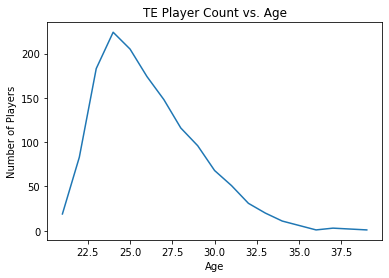

In [233]:
fig, ax = plt.subplots()
plt.plot(te_players_per_age['age'], te_players_per_age[0])
plt.title('TE Player Count vs. Age')
plt.xlabel('Age')
plt.ylabel('Number of Players')
plt.savefig('TE_players_v_age.png')
plt.show()

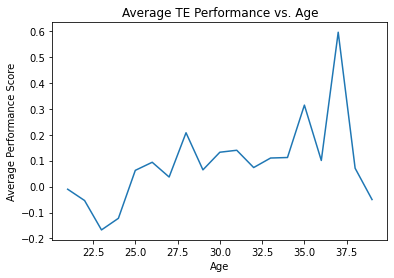

In [234]:

plt.plot(te_average_pca_per_age['age'], te_average_pca_per_age['PCA0'])
plt.title('Average TE Performance vs. Age')
plt.xlabel('Age')
plt.ylabel('Average Performance Score')
plt.savefig('TE_perf_v_age.png')
plt.show()